# Shopping Apps, Rating for Google Play Store and Apple AppStore Users

## Introduction

Users download apps for various purposes. Given that there is a rise in the usage of online shopping due to the Covid-19 pandemic, improvement of shopping experience has become more important then before. With that in mind, what are the important features we have to look out for to improve a shopping app?

More specifically, the questions to be answered:

- How do the app ratings differ across different shopping apps?
- Is there any specific group of users we can look out for to improve the app?
- Are there any specific improvement we can work on to further improve user experience of the app?

To explore and answer the above questions, we will scrap reviews from Google Play Store and Apple AppStore and conduct analysis and modelling.

# Import library

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from PIL import Image
from wordcloud import WordCloud

from bs4 import BeautifulSoup
import re
import spacy
from spacymoji import Emoji
from nltk.corpus import stopwords, words
from nltk import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


import sys
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Import Data

In [88]:
df = pd.read_csv('../data/cleaned_reviews.csv')

In [89]:
df.head()

,rating,date,app,store,review,clean_content,adj,noun,verb,emoji,neg_score,neu_score,pos_score,compound_score
0,5,2020-09-16 20:26:28,shoppee,google,Orders mostly came early and products are good.,came early good,good,order product,come,NaN,0.0,0.707,0.293,0.4404
1,4,2020-09-16 20:13:46,shoppee,google,Good and convenient,good convenient,good convenient,NaN,NaN,NaN,0.0,0.408,0.592,0.4404
2,5,2020-09-16 20:13:05,shoppee,google,Gd...........,NaN,NaN,NaN,NaN,NaN,0.0,1.000,0.000,0.0000
3,4,2020-09-16 20:11:18,shoppee,google,My first purchase experience...Happy with purchases. Thks,purchase experience happy,first happy,purchase experience purchase,NaN,NaN,0.0,0.714,0.286,0.3400
4,5,2020-09-16 20:08:54,shoppee,google,A lot of items at a very good deal.,lot good deal,good,lot item deal,NaN,NaN,0.0,0.715,0.285,0.4927


In [96]:
# lower all the adj, noun and verb
# use vader to get sentiment count
# plot sentiments of apps across time
# create new dataframe with all new data
df= df[df['clean_content'].notna()]
df.reset_index(inplace = True, drop = True)

In [97]:
df.isna().sum()

rating                0
date                  0
app                   0
store                 0
review                0
clean_content         0
adj               14022
noun              21875
verb              31718
emoji             69477
neg_score             0
neu_score             0
pos_score             0
compound_score        0
dtype: int64

In [98]:
df['app'].value_counts()

shoppee       11201
aliexpress    10101
wish           9600
ebay           9559
asos           9349
amazon         9318
lazada         8838
carousell      6195
Name: app, dtype: int64

In [99]:
df['date'] = df['date'].astype('datetime64')

In [100]:
df['date'].dt.year.value_counts()

2020    74161
Name: date, dtype: int64

In [101]:
df['app'].value_counts()

shoppee       11201
aliexpress    10101
wish           9600
ebay           9559
asos           9349
amazon         9318
lazada         8838
carousell      6195
Name: app, dtype: int64

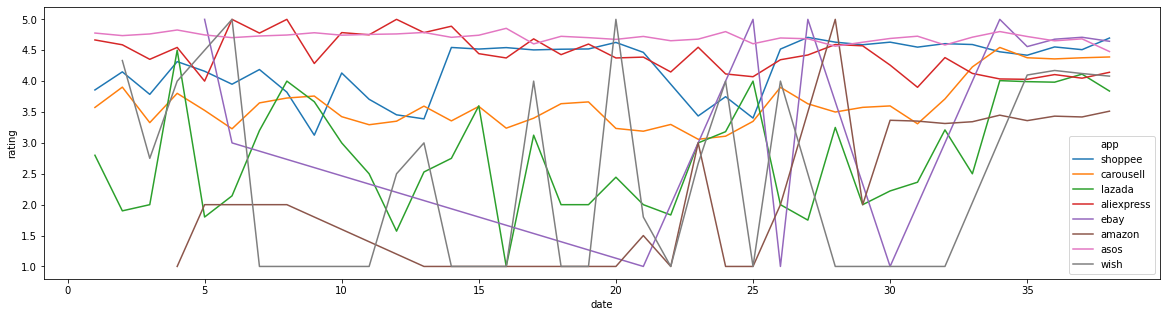

In [102]:
plt.figure(figsize = (20,5))
ax = sns.lineplot(x = df['date'].dt.week, 
             y = 'rating', 
             hue = 'app', 
             data = df,
             err_style = None, 
             markers = True)

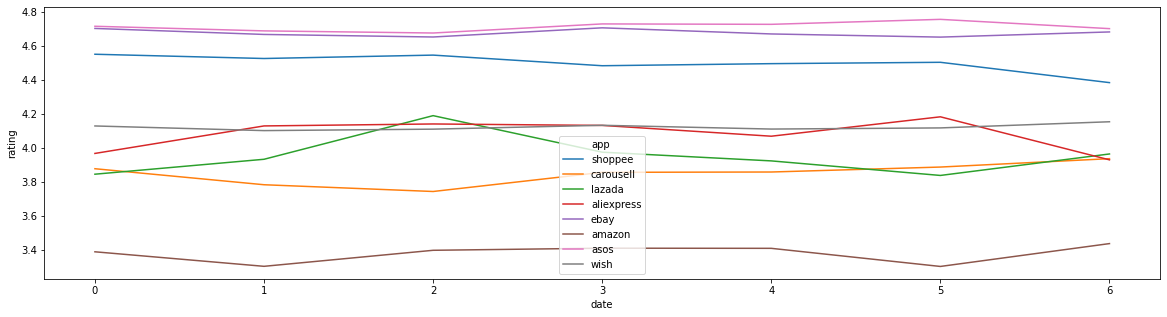

In [103]:
plt.figure(figsize = (20,5))
sns.lineplot(x = df['date'].dt.dayofweek, 
             y = 'rating', 
             hue = 'app', 
             data = df,
             err_style = None, 
             markers = True);

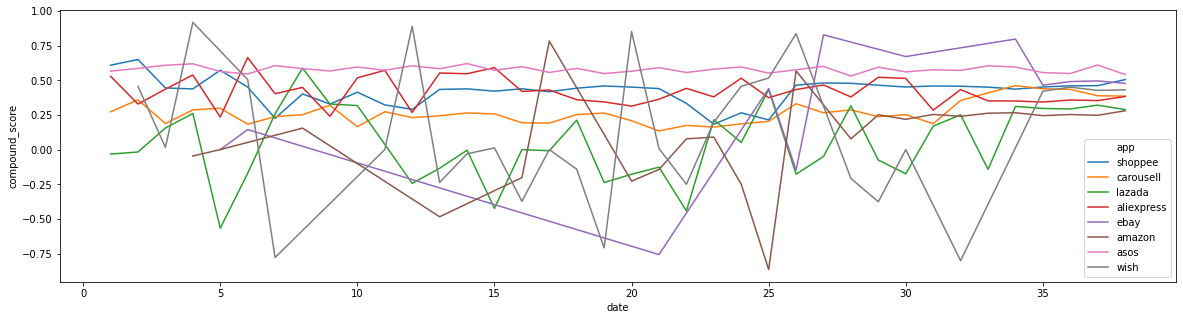

In [104]:
plt.figure(figsize = (20,5))
sns.lineplot(x = df['date'].dt.week,
             y = 'compound_score',
             hue = 'app',
             data = df,
             err_style = None, markers = True);

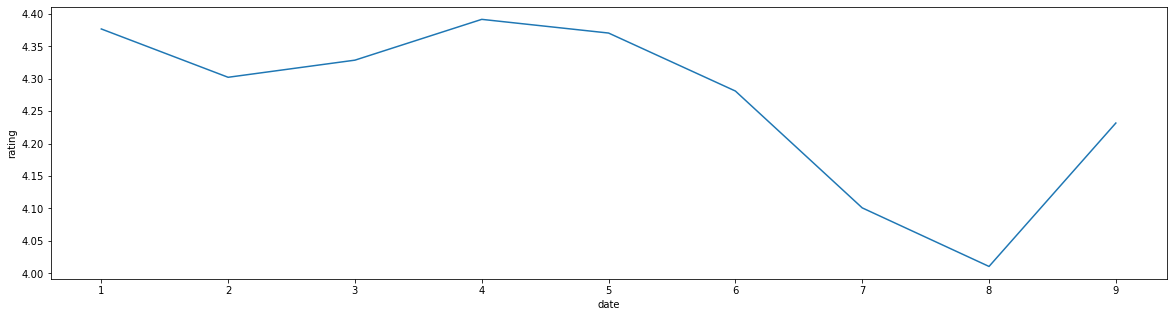

In [105]:
plt.figure(figsize = (20,5))
sns.lineplot(x = df['date'].dt.month,
             y = 'rating', 
             data = df,
             err_style = None,
             markers = True);

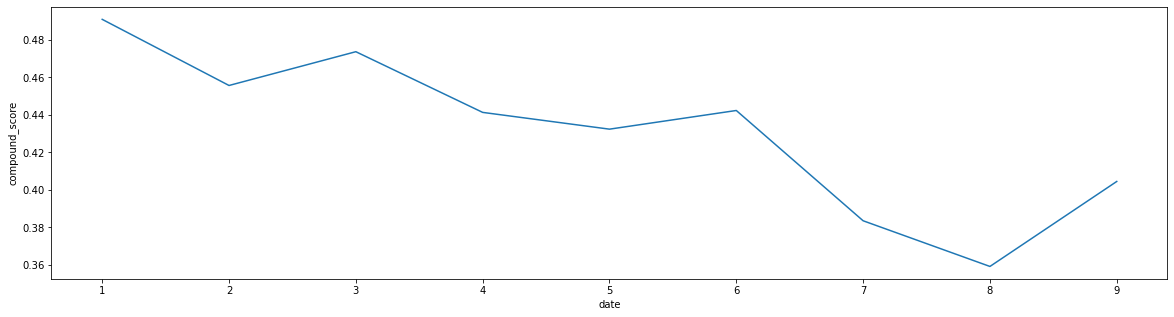

In [106]:
plt.figure(figsize = (20,5))
sns.lineplot(x = df['date'].dt.month,
             y = 'compound_score', 
             data = df,
             err_style = None,
             markers = True);

In [107]:
# compound score, how is it computed
# score of userreviews
# sentimental analysis,
# is review good or bad? 
# specific keywords to look out for
# created api app
# lda topic modeling
# creating topics with unsupervised learning to create groups
# able to see which group of people is more important to focus on

In [108]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.clean_content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['came', 'early', 'good']]


In [109]:
total_text = len(df['clean_content'])
print(f'There is a total of {total_text} selftext.')

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
stop_words = stopwords.words('english')


# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

There is a total of 74161 selftext.


In [110]:
len(data_ready)

74161

In [111]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.025*"item" + 0.024*"order" + 0.021*"time" + 0.020*"seller" + '
  '0.019*"receive" + 0.016*"service" + 0.014*"thank" + 0.014*"product" + '
  '0.013*"customer" + 0.012*"delivery"'),
 (1,
  '0.192*"good" + 0.054*"great" + 0.039*"shopping" + 0.037*"fast" + '
  '0.036*"platform" + 0.033*"delivery" + 0.025*"price" + 0.023*"find" + '
  '0.023*"experience" + 0.023*"far"'),
 (2,
  '0.098*"easy" + 0.089*"use" + 0.043*"shop" + 0.043*"love" + 0.039*"user" + '
  '0.037*"lot" + 0.034*"work" + 0.029*"search" + 0.023*"awesome" + '
  '0.022*"friendly"')]


In [112]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic,4),
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.3335,"good, great, shopping, fast, platform, delivery, price, find, experience, far","[come, early, good]"
1,1,1.0,0.7778,"good, great, shopping, fast, platform, delivery, price, find, experience, far","[good, convenient]"
2,2,0.0,0.5832,"item, order, time, seller, receive, service, thank, product, customer, delivery","[purchase, experience, happy]"
3,3,1.0,0.6667,"good, great, shopping, fast, platform, delivery, price, find, experience, far",[deal]
4,4,1.0,0.7747,"good, great, shopping, fast, platform, delivery, price, find, experience, far","[delivery, fast]"
5,5,0.0,0.6665,"item, order, time, seller, receive, service, thank, product, customer, delivery",[honest]
6,6,0.0,0.7712,"item, order, time, seller, receive, service, thank, product, customer, delivery","[new, user, set, payment, get, time, choose, package, delivery, time, item]"
7,7,1.0,0.4445,"good, great, shopping, fast, platform, delivery, price, find, experience, far","[fun, experience]"
8,8,1.0,0.6667,"good, great, shopping, fast, platform, delivery, price, find, experience, far",[good]
9,9,1.0,0.8333,"good, great, shopping, fast, platform, delivery, price, find, experience, far","[great, good, price]"


In [113]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9865,"item, order, time, seller, receive, service, thank, product, customer, delivery","[remove, wish, phone, unimpressed, standard, product, offer, approximately, year, later, receive..."
1,1.0,0.9385,"good, great, shopping, fast, platform, delivery, price, find, experience, far","[find, great, good, stuff, find, pretty, unique, express, style, well]"
2,2.0,0.9259,"easy, use, shop, love, user, lot, work, search, awesome, friendly","[user, toykingking, user, hobbycollector, iplay, user, phosphophylite, user]"


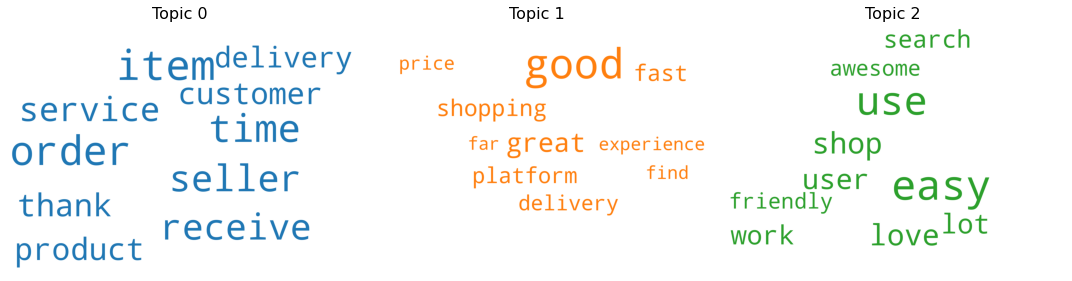

In [114]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(ncols=3, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

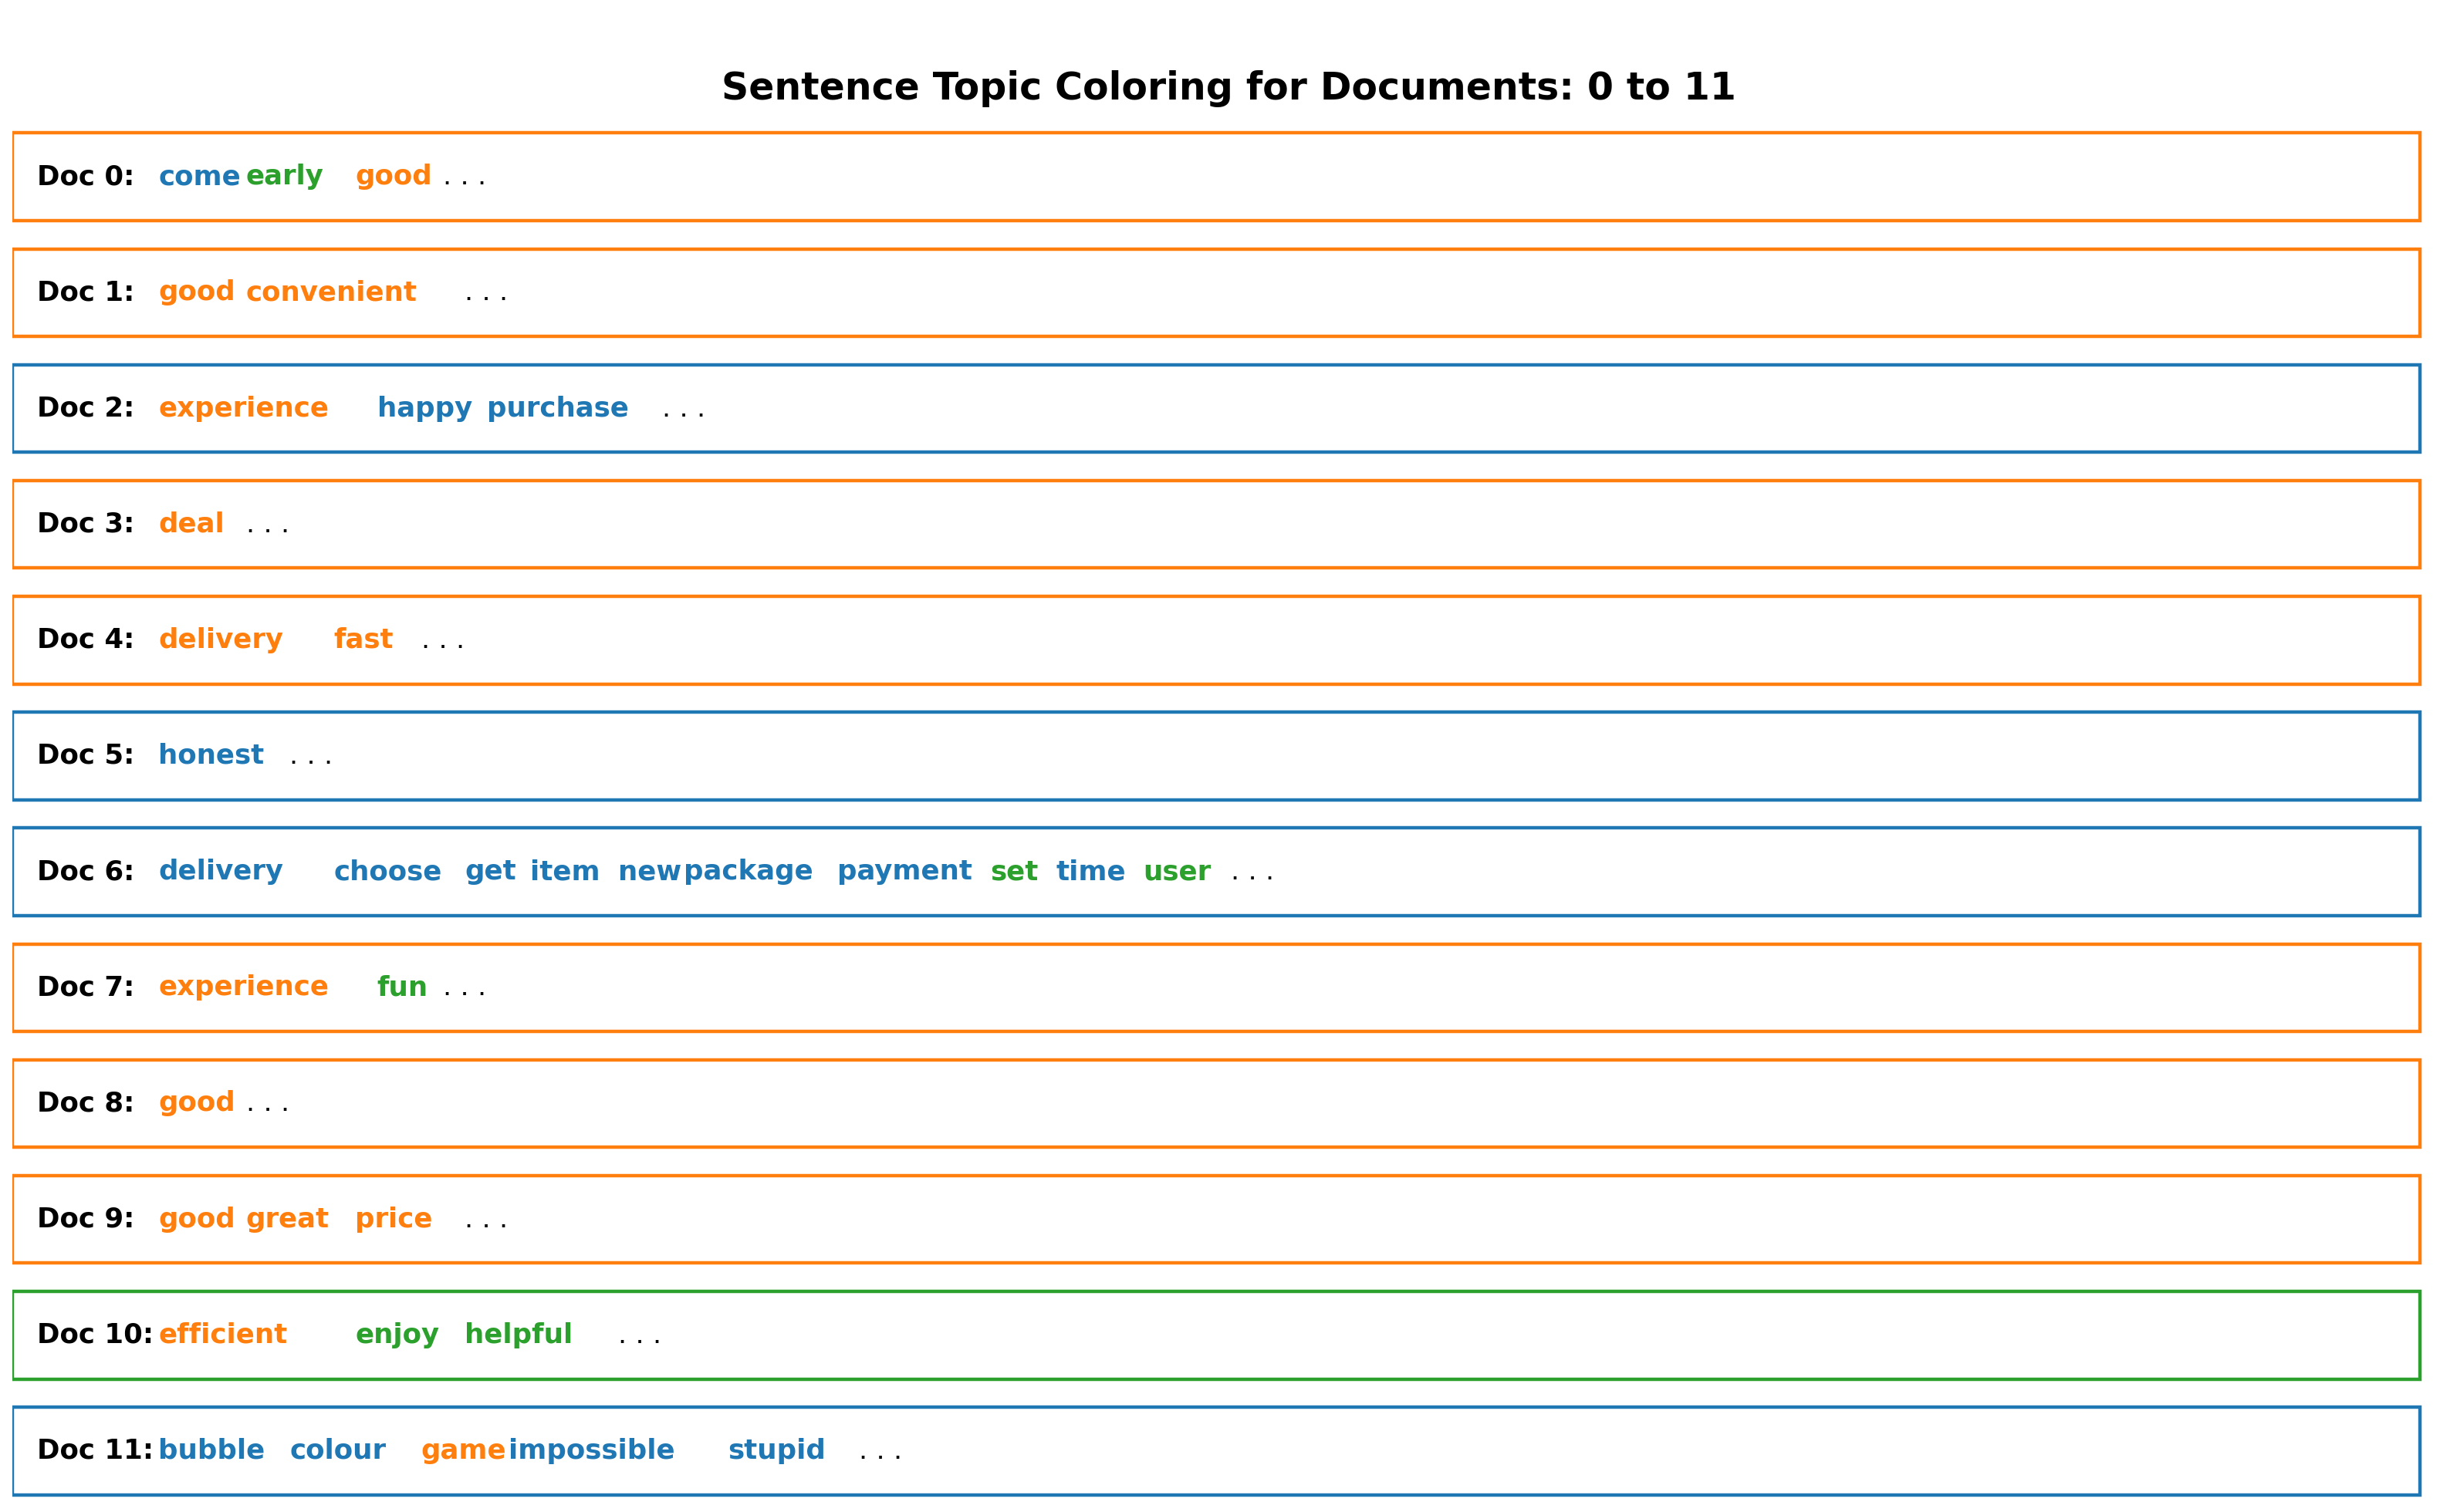

In [115]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart() 

In [116]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.094765 -0.333160       1        1  52.280605
1     -0.249357  0.246377       2        1  26.819389
2      0.344121  0.086783       3        1  20.900005, topic_info=            Term          Freq         Total Category  logprob  loglift
2           good  16107.000000  16107.000000  Default  30.0000  30.0000
36          easy   6378.000000   6378.000000  Default  29.0000  29.0000
38           use   5830.000000   5830.000000  Default  28.0000  28.0000
21         great   4491.000000   4491.000000  Default  27.0000  27.0000
47          shop   2808.000000   2808.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
730      feature    353.530090    355.526520   Topic3  -5.2193   1.5598
120   responsive    461.786621    468.537048   Topic3  -4.9522   1.5509
256    interface    357.026337    359.625305   Topic3  -5.2095   1.5582
372      selling    589.313782    627.560303   Topic3  -4.7083   1.5025
433  transaction    502.986237    667.268799   Topic3  -4.8667   1.2828

[139 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
367       3  0.998021     access
278       1  0.999700    account
698       2  0.997794   accurate
698       3  0.001738   accurate
258       3  0.998751    amazing
...     ...       ...        ...
254       1  0.999270       want
73        1  0.999077        way
186       2  0.999678       well
579       3  0.998731  wonderful
274       3  0.999896       work

[134 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])